# Assignment 8

# Submission Requirements:

Submit a Jupyter notebook named modeling.ipynb containing:
1. Clear markdown cells explaining your approach
2. Well-commented code cells showing your analysis
3. Visualizations of results where appropriate
4. Interpretations of your findings
5. Your notebook should demonstrate proper data handling, statistical analysis, and machine learning practices as covered in the lectures.


# Data Source

The data is generated using `generate_health_data.py`, which creates three tab-separated (TSV) datasets:

1. `patient_baseline.csv`: Patient demographics and initial measurements
   - `patient_id`: Unique identifier
   - `age`: Age in years
   - `sex`: Binary (0=male, 1=female)
   - `bmi`: Body mass index
   - `smoking`: Binary smoking status
   - `diabetes`: Binary diabetes status
   - `bp_systolic`: Systolic blood pressure
   - `cholesterol`: Total cholesterol
   - `heart_rate`: Heart rate

2. `patient_longitudinal.csv`: Blood pressure and heart rate measurements over time
   - `patient_id`: Unique identifier
   - `visit_date`: Date of measurement (YYYY-MM-DD)
   - `bp_systolic`: Systolic blood pressure
   - `heart_rate`: Heart rate
   - `adverse_event`: Binary indicator of cardiovascular event
   - Plus baseline characteristics

3. `patient_treatment.csv`: Treatment assignments and outcomes
   - All baseline characteristics
   - `treatment`: Binary indicator of receiving treatment
   - `adherence`: Percentage of prescribed medication taken
   - `outcome`: Binary indicator of reaching treatment goal

# Importing all necessary libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# Importing our datasets and running exploratory data analysis

In this section, we will be importing all our datasets into dataframes and running EDA on them so that we may better understand the data.

## Baseline Dataset

In [11]:
baseline = pd.read_csv('patient_baseline.csv', delimiter='\t')

baseline.head()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0
3,3,72.8,1,34.6,0,1,141.0,205.7,78.0
4,4,46.5,0,17.5,0,0,129.0,186.8,95.2


In [12]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   1000 non-null   int64  
 1   age          1000 non-null   float64
 2   sex          1000 non-null   int64  
 3   bmi          1000 non-null   float64
 4   smoking      1000 non-null   int64  
 5   diabetes     1000 non-null   int64  
 6   bp_systolic  1000 non-null   float64
 7   cholesterol  1000 non-null   float64
 8   heart_rate   1000 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 70.4 KB


In [13]:
baseline.describe()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000
mean,499.500000,50.319300,0.515000,27.095600,0.274000,0.282000,134.552400,205.390400,77.4556
std,288.819436,14.470555,0.500025,4.882655,0.446232,0.450198,12.408951,22.125587,11.5321
min,0.000000,18.000000,0.000000,15.000000,0.000000,0.000000,97.500000,140.300000,44.5000
25%,249.750000,40.275000,0.000000,23.800000,0.000000,0.000000,125.875000,190.875000,69.4000
50%,499.500000,50.400000,1.000000,27.000000,0.000000,0.000000,134.400000,205.350000,77.7000
75%,749.250000,59.700000,1.000000,30.300000,1.000000,1.000000,142.425000,219.500000,85.5000
max,999.000000,90.000000,1.000000,43.000000,1.000000,1.000000,177.300000,293.100000,112.6000


In [14]:
baseline.isnull().sum()

patient_id     0
age            0
sex            0
bmi            0
smoking        0
diabetes       0
bp_systolic    0
cholesterol    0
heart_rate     0
dtype: int64

Since 'sex', 'smoking', 'diabetes' are our only binary variables, let's see their value counts

In [20]:
for col in ['sex', 'smoking', 'diabetes']:
    print("Value counts for: ", col, "\n",baseline[col].value_counts(), "\n")

Value counts for:  sex 
 1    515
0    485
Name: sex, dtype: int64 

Value counts for:  smoking 
 0    726
1    274
Name: smoking, dtype: int64 

Value counts for:  diabetes 
 0    718
1    282
Name: diabetes, dtype: int64 



As is standard, we can assume that 0 means No and 1 means Yes for smoking and diabetes.


Let's plot out the distributions of the numerical columns just to see.

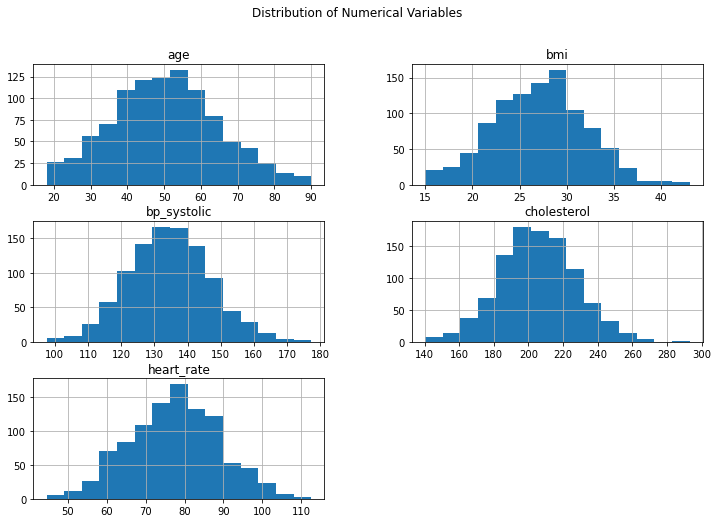

In [26]:
numerical_columns = ['age', 'bmi', 'bp_systolic', 'cholesterol', 'heart_rate']

baseline[numerical_columns].hist(bins=15, figsize=(12, 8))
plt.suptitle("Distribution of Numerical Variables")
plt.show()

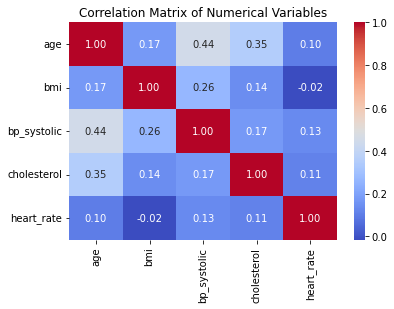

In [22]:
correlation_matrix = baseline[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

## Longitudinal Dataset

In [58]:
longitudinal = pd.read_csv('patient_longitudinal.csv', delimiter='\t')
longitudinal.head()

,patient_id,visit_date,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
0,0,2023-01-17,108.6,72.4,0,57.5,0.0,25.8,0.0,0.0
1,0,2023-02-22,104.8,71.9,0,57.5,0.0,25.8,0.0,0.0
2,0,2023-03-23,106.3,76.2,0,57.5,0.0,25.8,0.0,0.0
3,0,2023-04-16,110.8,76.5,0,57.5,0.0,25.8,0.0,0.0
4,0,2023-06-05,117.7,78.4,0,57.5,0.0,25.8,0.0,0.0


In [59]:
longitudinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61000 entries, 0 to 60999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     61000 non-null  int64  
 1   visit_date     61000 non-null  object 
 2   bp_systolic    61000 non-null  float64
 3   heart_rate     61000 non-null  float64
 4   adverse_event  61000 non-null  int64  
 5   age            61000 non-null  float64
 6   sex            61000 non-null  float64
 7   bmi            61000 non-null  float64
 8   smoking        61000 non-null  float64
 9   diabetes       61000 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 4.7+ MB


Converting visit_date to datetime format

In [60]:
longitudinal.isnull().sum()

patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64

In [61]:
longitudinal.describe()

,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
count,61000.000000,61000.000000,61000.000000,61000.000000,61000.000000,61000.000000,61000.000000,61000.000000,61000.000000
mean,499.500000,134.454487,77.983184,0.094492,50.319300,0.515000,27.095600,0.274000,0.282000
std,288.677356,18.642552,18.107739,0.292514,14.463437,0.499779,4.880253,0.446013,0.449977
min,0.000000,51.600000,1.800000,0.000000,18.000000,0.000000,15.000000,0.000000,0.000000
25%,249.750000,122.100000,66.000000,0.000000,40.275000,0.000000,23.800000,0.000000,0.000000
50%,499.500000,134.300000,77.900000,0.000000,50.400000,1.000000,27.000000,0.000000,0.000000
75%,749.250000,146.800000,89.600000,0.000000,59.700000,1.000000,30.300000,1.000000,1.000000
max,999.000000,209.700000,152.800000,1.000000,90.000000,1.000000,43.000000,1.000000,1.000000


The patient_id column is identical to the one from earlier. It is extremely unusual to have a mean of 499.5 for 61000 values unless we have repeating patient_id which does make sense.

In [62]:
visits_per_patient_long = longitudinal['patient_id'].value_counts().mean()
visits_per_patient_base = baseline['patient_id'].value_counts().mean()
print("Longitudinal visits: ", visits_per_patient_long)
print("Baseline visits: ", visits_per_patient_base)

Longitudinal visits:  61.0
Baseline visits:  1.0


This output makes sense since the baseline only has 1 visit per patient and the longitudinal data has 61 visits per patient worth of data to analyze from.

In [63]:
print("Value counts for adverse_event:\n", longitudinal['adverse_event'].value_counts())

Value counts for adverse_event:
 0    55236
1     5764
Name: adverse_event, dtype: int64


## Treatment Dataset

In [45]:
treatment = pd.read_csv('patient_treatment.csv', delimiter='\t')
treatment.head()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate,treatment,adherence,outcome
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3,0,0.81,0
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4,1,0.91,1
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0,1,0.73,1
3,3,72.8,1,34.6,0,1,141.0,205.7,78.0,1,0.91,1
4,4,46.5,0,17.5,0,0,129.0,186.8,95.2,0,0.77,0


In [46]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   1000 non-null   int64  
 1   age          1000 non-null   float64
 2   sex          1000 non-null   int64  
 3   bmi          1000 non-null   float64
 4   smoking      1000 non-null   int64  
 5   diabetes     1000 non-null   int64  
 6   bp_systolic  1000 non-null   float64
 7   cholesterol  1000 non-null   float64
 8   heart_rate   1000 non-null   float64
 9   treatment    1000 non-null   int64  
 10  adherence    1000 non-null   float64
 11  outcome      1000 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 93.9 KB


In [47]:
treatment.describe()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate,treatment,adherence,outcome
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.00000,1000.000000,1000.000000
mean,499.500000,50.319300,0.515000,27.095600,0.274000,0.282000,134.552400,205.390400,77.4556,0.58400,0.721320,0.384000
std,288.819436,14.470555,0.500025,4.882655,0.446232,0.450198,12.408951,22.125587,11.5321,0.49314,0.138376,0.486601
min,0.000000,18.000000,0.000000,15.000000,0.000000,0.000000,97.500000,140.300000,44.5000,0.00000,0.260000,0.000000
25%,249.750000,40.275000,0.000000,23.800000,0.000000,0.000000,125.875000,190.875000,69.4000,0.00000,0.630000,0.000000
50%,499.500000,50.400000,1.000000,27.000000,0.000000,0.000000,134.400000,205.350000,77.7000,1.00000,0.730000,0.000000
75%,749.250000,59.700000,1.000000,30.300000,1.000000,1.000000,142.425000,219.500000,85.5000,1.00000,0.820000,1.000000
max,999.000000,90.000000,1.000000,43.000000,1.000000,1.000000,177.300000,293.100000,112.6000,1.00000,1.000000,1.000000


In [48]:
print(treatment['patient_id'].nunique())

1000


In [49]:
treatment.isnull().sum()

patient_id     0
age            0
sex            0
bmi            0
smoking        0
diabetes       0
bp_systolic    0
cholesterol    0
heart_rate     0
treatment      0
adherence      0
outcome        0
dtype: int64

Lets create some graphs to see the distribution of Treatment Assignment and the Distribution of Treatment Outcomes

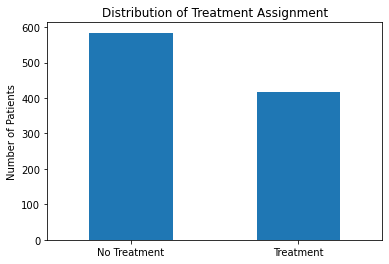

In [52]:
treatment['treatment'].value_counts().plot(kind='bar', title='Distribution of Treatment Assignment')
plt.ylabel('Number of Patients')
plt.xticks(ticks=[0, 1], labels=['No Treatment', 'Treatment'], rotation=0)
plt.show()

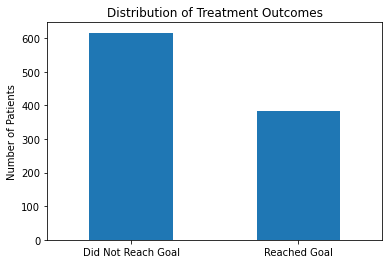

In [53]:
treatment['outcome'].value_counts().plot(kind='bar', title='Distribution of Treatment Outcomes')
plt.ylabel('Number of Patients')
plt.xticks(ticks=[0, 1], labels=['Did Not Reach Goal', 'Reached Goal'], rotation=0)
plt.show()

# Begin Assignment

Now that we have loaded in our datasets and have a rough idea of their contents through EDA, we can begin working on the assignment.

## Part 1: Time Series Tasks

### Part 1.1: Convert the longitudinal blood pressure measurements into a proper time series:

- Create a pandas Series with DatetimeIndex using visit_date
- Handle any missing or duplicate measurements appropriately


Tips:
- Use pd.to_datetime() with format='%Y-%m-%d' for reliable parsing
- Handle duplicates with duplicated() and appropriate aggregation
- Consider timezone handling with tz_localize() if needed
- Use interpolate() or fillna() for missing values


Converting to datetime format and grouping the dataset

In [64]:
#Converting visit_date to proper datetime format
longitudinal['visit_date'] = pd.to_datetime(longitudinal['visit_date'], errors='coerce')

#sorting to group the values by patient_id and visit_date
longitudinal = longitudinal.sort_values(by=['patient_id', 'visit_date'])

Handling duplicated values and missing values with aggregation

In [65]:
longitudinal_grouped = longitudinal.groupby(['patient_id', 'visit_date']).agg({
    'bp_systolic': 'mean',
    'heart_rate': 'mean',
    'adverse_event': 'max'}).reset_index()

Setting the index of the grouped dataframe as the visit_date

In [66]:
longitudinal_grouped.set_index('visit_date', inplace=True)

Filling in missing values with forward fill

In [67]:
longitudinal_grouped['bp_systolic'] = longitudinal_grouped['bp_systolic'].fillna(method='ffill')
longitudinal_grouped['heart_rate'] = longitudinal_grouped['heart_rate'].fillna(method='ffill')

Creating the time series for blood pressure

In [68]:
time_series_bp = {}

for patient_id in longitudinal_grouped['patient_id'].unique():
    patient_data = longitudinal_grouped[longitudinal_grouped['patient_id'] == patient_id]

    # Create a pandas Series for blood pressure
    time_series_bp[patient_id] = pd.Series(
        patient_data['bp_systolic'].values,
        index=patient_data.index
    )

Checking what we have in time_series_bp for a single patient_id

In [73]:
a=0
for patient_id in longitudinal_grouped['patient_id'].unique():
    print(time_series_bp[patient_id])
    a+=1
    if a==1:
        break

visit_date
2023-01-17    108.6
2023-02-22    104.8
2023-03-23    106.3
2023-04-16    110.8
2023-06-05    117.7
2023-06-16    118.0
2023-06-21    119.9
2023-07-03    115.5
2023-08-23    119.2
2023-10-13    121.2
2023-10-20    120.0
2023-12-13    123.1
2024-01-17    122.4
2024-03-01    121.3
2024-03-14    122.4
2024-04-04    119.8
2024-04-17    122.5
2024-05-19    119.7
2024-05-25    114.8
2024-07-03    117.1
2024-10-05    115.2
2024-10-21    116.7
2024-11-14    111.8
2024-12-07    110.2
2025-01-19    110.3
2025-02-20    107.3
2025-02-25    104.4
2025-03-25    109.7
2025-04-03    107.5
2025-06-17    105.8
2025-06-23    106.3
2025-07-31    106.7
2025-08-26    104.7
2025-11-12    108.7
2025-12-04    104.8
2025-12-08    107.9
2025-12-22    108.0
2026-01-26    106.5
2026-02-14    107.8
2026-04-28    111.8
2026-05-24    112.1
2026-05-30    107.0
2026-06-30    110.9
2026-07-22    110.3
2026-08-15    111.0
2026-09-19    108.9
2026-09-30    109.6
2026-10-26    106.5
2027-01-07    108.0
2027-02-1

### Part 1.2 Analyze blood pressure trends:

- Resample the data to monthly frequency using mean aggregation
- Calculate 3-month moving averages to smooth out short-term fluctuations
- Visualize both the original and smoothed trends

Tips:
- Use resample('ME').mean() for month-end frequency
- Add min_periods to rolling() to handle edge cases
- Consider interpolate() method for gaps
- Use ewm() for exponential weighted alternatives

According to the instructions, if we want to visualize both the original and smoothed trends for the ENTIRE dataset, we would have to create 1000 plots which isn't really feasible. So, for this example, we will be considering patient_id = 1.

Here, we set our working variables and resample the data to monthly frequency and calculate the mean

In [76]:
patient_id = 1
bp_series = time_series_bp[patient_id]
monthly_bp = bp_series.resample('M').mean()

Calculate 3-month moving average: 

In [77]:
monthly_bp_smoothed = monthly_bp.rolling(window=3, min_periods=1).mean()

Calculating exponential weighted moving average:

In [78]:
monthly_bp_ewm = monthly_bp.ewm(span=3).mean()

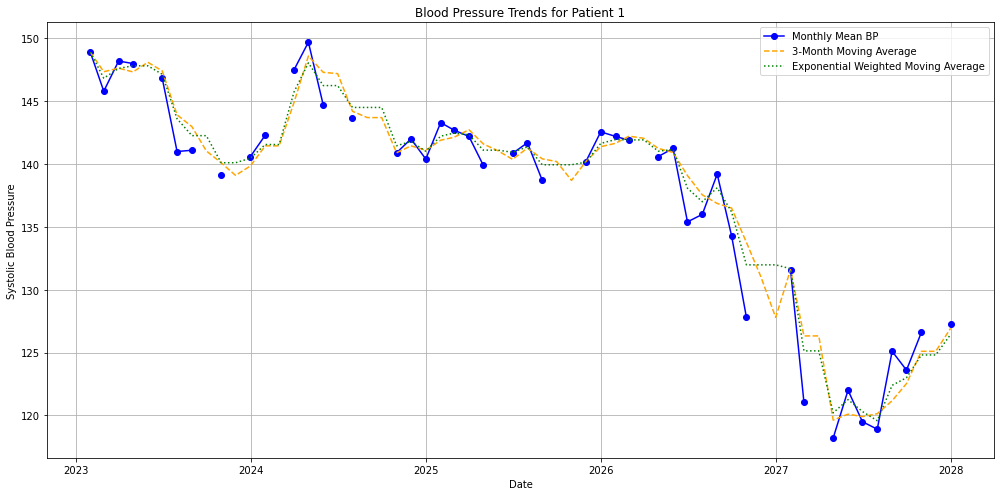

In [83]:
plt.figure(figsize=(14, 7))
plt.plot(monthly_bp.index, monthly_bp, label='Monthly Mean BP', color='blue', marker='o')
plt.plot(monthly_bp_smoothed.index, monthly_bp_smoothed, label='3-Month Moving Average', color='orange', linestyle='--')
plt.plot(monthly_bp_ewm.index, monthly_bp_ewm, label='Exponential Weighted Moving Average', color='green', linestyle=':')


#Adding a Title, X-axis label, Y-axis label, legend, and grid
plt.title(f'Blood Pressure Trends for Patient {patient_id}')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Part 2: Statistical Modeling Tasks

### Part 2.1: Analyze factors affecting baseline blood pressure:

- Use statsmodels OLS to predict bp_systolic
- Include age, bmi, smoking, and diabetes as predictors
- Interpret the coefficients and their p-values
- Assess model fit using R-squared and diagnostic plots

Tips:
- Create feature matrix X with predictors and add constant term using sm.add_constant()
- Use sm.OLS(y, X).fit() to fit the model
- Use summary() to examine p-values and confidence intervals
- Plot residuals vs fitted values and Q-Q plot
- Consider robust standard errors with HC3 covariance type

Preparing the data, with the constant term for the intercept.

In [86]:
y = baseline['bp_systolic']
X = baseline[['age', 'bmi', 'smoking', 'diabetes']]

X = sm.add_constant(X)

Fitting an Ordinary Least Squares (OLS) model

In [87]:
model = sm.OLS(y, X).fit()

In [89]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Wed, 06 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        00:22:59   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

The analysis of the coefficients and their p-values are:

1.  Intercept:
    - Coefficient = 108.49
    - This represents the expected systolic blood pressure when all predictor variables are equal to zero. 
2. Age: 
    - Coefficient = 0.284
    - For each additional year in age, systolic blood pressure is expected to increase by 0.284 mmHg. Since the P value = 0, this effect is very statistically significant in that an increase in age correlates heavily with an increase in Systolic Blood Pressure.
3. BMI:
    - Coefficient = 0.2786
    - Each unit increase in BMI is associated with a rise of 0.279 mmHg in systolic blood pressure. The p value is 0 so, this effect is also very statistically significant in that an increase in BMI correlates heavily with an increase in Systolic Blood Pressure.
4. Smoking: 
    - Coefficient = 5.2412
    - Smokers have systolic blood pressure levels that are, on average, 5.2412 mmHg higher than non-smokers. The p value of 0 indicates a strong correlation between smoking and increased blood pressure
5. Diabetes:
    - Coefficient = 9.8732
    - The presence of diabetes in an individual generally accounts for an increase of 9.873 mmHg in systolic blood pressure compared to non-diabetic individuals. The p value is 0 which indicates a very statistically significant relationship between diabetes and blood pressure.

Since all of these factors have positive coefficients, an increase in any of the values of these factors is predicted to result in an increase in systolic blood pressure.


Assessing the model using r-squared

In [92]:
r_squared = model.rsquared
print(f"R-squared: {r_squared:.3f}")

R-squared: 0.376


Diagnostic Plots:

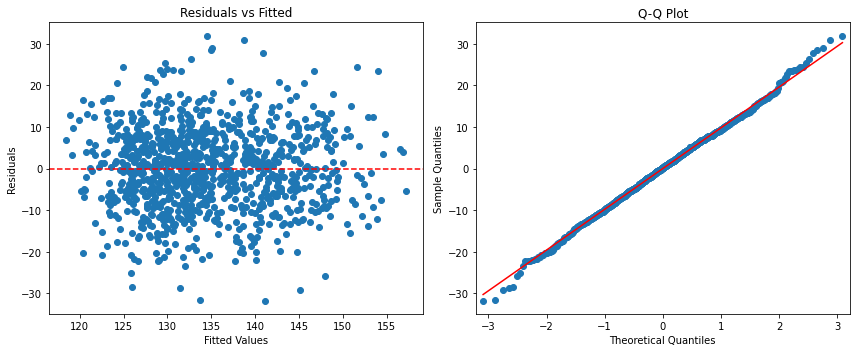

In [96]:
# Residuals vs Fitted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(model.resid, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

### Part 2.2: Model treatment effectiveness:

- Fit a GLM with binomial family to predict treatment success
- Use baseline characteristics and adherence as predictors
- Report odds ratios and their confidence intervals
- Assess model fit using deviance and diagnostic plots

Tips:
- Create feature matrix X with predictors and add constant term
- Use sm.GLM(y, X, family=sm.families.Binomial()).fit()
- Get odds ratios with np.exp(params)
- Check residual deviance vs null deviance
- Use influence() to detect influential observations

Preparing the data

In [97]:
X_treatment = treatment[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
X_treatment = sm.add_constant(X_treatment)  
y_treatment = treatment['outcome']  

Creating and fitting the Generalized Linear Model (GLM)

In [98]:
model_treatment = sm.GLM(y_treatment, X_treatment, family=sm.families.Binomial()).fit()

In [99]:
print(model_treatment.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Wed, 06 Nov 2024   Deviance:                       1312.8
Time:                        00:42:20   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

Reporting the Odds ratios and their confidence intervals

In [100]:
params = model_treatment.params

# Calculate odds ratios
odds_ratios = np.exp(params)  

# Getting confidence intervals
conf = model_treatment.conf_int()  

# Transform confidence intervals to odds ratios
conf_odds_ratios = np.exp(conf)  

#Combining into a DataFrame and printing results
odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5% CI': conf_odds_ratios[0],
    '97.5% CI': conf_odds_ratios[1]
})

print(odds_ratios_df)

           Odds Ratio   2.5% CI  97.5% CI
const        0.281360  0.072687  1.089105
age          1.002744  0.993428  1.012147
bmi          1.030101  1.001936  1.059058
smoking      0.677929  0.456134  1.007574
diabetes     0.613448  0.438726  0.857752
adherence    1.129833  0.305350  4.180529


Assessing model fit using deviance:

In [103]:
deviance = model_treatment.deviance
null_deviance = model_treatment.null_deviance
print("Deviance: ",deviance)
print("Null Deviance: ",null_deviance)
print("Difference (Deviance - Null Deviance)= ", null_deviance - deviance)

Deviance:  1312.832088524959
Null Deviance:  1331.9768185036041
Difference (Deviance - Null Deviance)=  19.144729978645046


Creating Diagnostics plots: 

First we create an influence plot

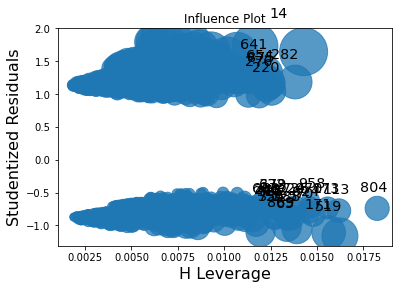

In [104]:
influence = model_treatment.get_influence()
influence_plot = influence.plot_influence()
plt.title("Influence Plot")
plt.show()

Plotting Residuals vs Fitted

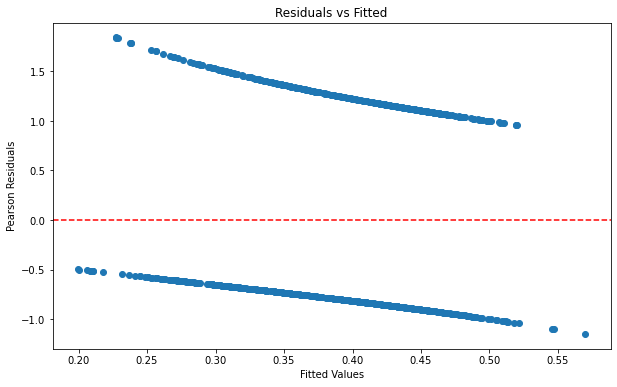

In [105]:
plt.figure(figsize=(10, 6))
plt.scatter(model_treatment.fittedvalues, model_treatment.resid_pearson)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Pearson Residuals')
plt.show()

## Part 3 (Stretch Goal): Machine Learning Tasks

### Part 3.0: sklearn imports

In [121]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score

### Part 3.1: Build a prediction pipeline:

- Create features from baseline characteristics
- Standardize numeric features using StandardScaler
- Train a logistic regression model to predict treatment outcomes
- Include regularization to prevent overfitting

Tips: 
- Use ColumnTransformer for mixed numeric/categorical features
- Consider SelectKBest or RFE for feature selection
- Try different regularization strengths with C parameter
- Use Pipeline to prevent data leakage

In [114]:
X_new = treatment[['age','bmi','smoking','diabetes','sex','adherence']]
y_new = treatment['outcome']


X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [115]:
numeric_features = ['age', 'bmi', 'smoking', 'diabetes']
categorical_features = ['sex']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [116]:
pipeline = make_pipeline(
    preprocessor,
    SelectKBest(f_classif, k = 'all'),
    LogisticRegression(
        penalty = 'l2',
        solver= 'lbfgs',
        max_iter=1000,
        class_weight='balanced'
    )
)

In [117]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'smoking',
                                                   'diabetes']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex'])])),
                ('selectkbest', SelectKBest(k='all')),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [118]:
y_pred = pipeline.predict(X_test)

In [120]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.56      0.60       127
           1       0.39      0.49      0.44        73

    accuracy                           0.54       200
   macro avg       0.52      0.53      0.52       200
weighted avg       0.56      0.54      0.54       200



### Part 3.2: Validate model performance:

- Split data into 70% training and 30% test sets
- Implement 5-fold cross-validation on the training set
- Report accuracy, precision, recall, and ROC AUC
- Generate confusion matrix and ROC curve

Tips: 
- Use StratifiedKFold for imbalanced datasets
- Consider precision-recall curve for imbalanced data
- Plot learning curves to diagnose bias/variance
- Use cross_validate for multiple metrics at once

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

In [124]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
cv_results = cross_validate(
    pipeline, X_train, y_train, cv = cv, scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    return_train_score=False
)

print("Cross-validation results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")


Cross-validation results:
Accuracy: 0.5729
Precision: 0.4668
Recall: 0.6077
ROC AUC: 0.5859


In [125]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'smoking',
                                                   'diabetes']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex'])])),
                ('selectkbest', SelectKBest(k='all')),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [128]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       189
           1       0.39      0.50      0.44       111

    accuracy                           0.53       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.55      0.53      0.53       300



In [130]:
roc_auc = roc_auc_score(y_test, y_prob)
print(roc_auc)

0.5258830258830259


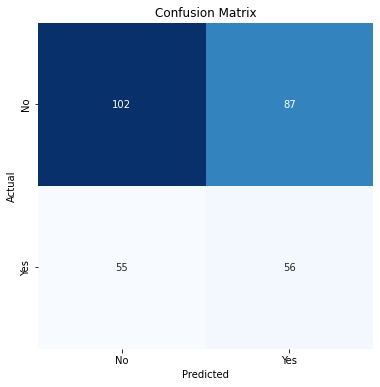

In [131]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

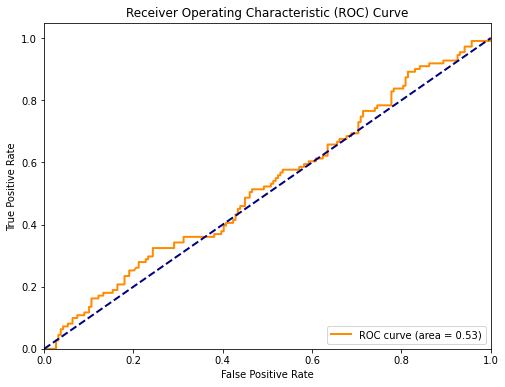

In [133]:
a, b, c = roc_curve(y_test, y_prob)
roc_auc = auc(a, b)

plt.figure(figsize=(8, 6))
plt.plot(a, b, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
